In [1]:
argv=['','/home/daniel/SAM_Data_Models/Data/Actions2', '/home/daniel/SAM_Data_Models/Models/', 'train_actions2', 'new','return']

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import readline
import warnings
import GPy
from SAM.SAM_Drivers import SAMDriver_AR
from SAM.SAM_Core import SAMCore
from SAM.SAM_Core import SAMDriver
import pylab as pb
import sys 
from sys import executable
import subprocess
from subprocess import Popen, PIPE
import pickle
import os
from os import listdir, walk, system
from os.path import isfile, join, isdir
import time
import operator
import numpy

import numpy as np
import numpy.ma as ma
np.set_printoptions(threshold=numpy.nan)
import datetime
import yarp
import copy
from itertools import combinations 
from ConfigParser import SafeConfigParser
import math
import ipyparallel as ipp
import random

warnings.simplefilter("ignore")

In [3]:
yarpRunning = False
dataPath = argv[1]
modelPath = argv[2]
trainName = argv[3]
mode = argv[4]
if(len(argv) > 5):
    returnMode = True
singleModel = False

#participantList is extracted from number of subdirectories of dataPath
participantList = [f for f in listdir(dataPath) if isdir(join(dataPath, f))]
if (len(participantList) < 1):
    singleModel = True

off = 17
print '-------------------'
print 'Training Settings:'
print
print 'Data Path: '.ljust(off), dataPath
print 'Model Path: '.ljust(off),modelPath
print 'Participants: '.ljust(off),participantList
print 'Model Root Name: '.ljust(off), trainName
print 'Training Mode:'.ljust(off), mode
print '-------------------'
print 'Loading Parameters...'
print

try:
    parser = SafeConfigParser()
    found = parser.read(dataPath + "/config.ini")

    if(parser.has_option(trainName, 'update_mode')):
        modeConfig = parser.get(trainName, 'update_mode') 
    else:
        modeConfig = 'update'
except IOError:
    pass

if(mode == 'new' or modeConfig == 'new' or '.pickle' not in modelPath): #or update but no .pickle
    print 'Loading training parameters from: \n ', '\t' + dataPath + "/config.ini"
    try:
        parser = SafeConfigParser()
        found = parser.read(dataPath + "/config.ini")

        #load parameters from config file
        if(parser.has_option(trainName, 'ignoreLabels')):
            ignoreLabels = parser.get(trainName, 'ignoreLabels').split(',')
        else:
            ignoreLabels = ['agent_entry','agent_exit','no_agent']
        
        if(parser.has_option(trainName, 'actionsAllowedList')):
            actionsAllowedList = parser.get(trainName, 'actionsAllowedList').split(',')
        else:
            actionsAllowedList = ['lift_object','pull_object','push_object','drop_object','carry_object']
        
        if(parser.has_option(trainName, 'percentContactThreshold')):
            percentContactThreshold = float(parser.get(trainName, 'percentContactThreshold'))
        else:
            percentContactThreshold = 98.0
        
        if(parser.has_option(trainName, 'jointMu')):
            jointMu = float(parser.get(trainName, 'jointMu'))
        else:
            jointMu = 0
            
        if(parser.has_option(trainName, 'jointSig')):
            jointSig = float(parser.get(trainName, 'jointSig'))
        else:
            jointSig = 0.0000001

        if(parser.has_option(trainName, 'featuresToUse')):
            featuresToUse = parser.get(trainName, 'featuresToUse').split(',')
        else:
            featuresToUse = ['contact','selfMovementLabelK']
        
        if(parser.has_option(trainName, 'ignoreParts')):
            ignoreParts = parser.get(trainName, 'ignoreParts').split(',')
        else:
            ignoreParts = ['partner']
            
        if(parser.has_option(trainName, 'compressData')):
            compressData = parser.get(trainName, 'compressData')
        else:
            compressData = True
        
        if(parser.has_option(trainName, 'featuresToCompress')):
            featuresToCompress = parser.get(trainName, 'featuresToCompress').split(',')
        else:
            featuresToCompress = ['selfMovementLabelK']

        if(parser.has_option(trainName, 'experiment_number')):
            experiment_number = int(parser.get(trainName, 'experiment_number'))
        elif('.pickle' in modelPath):
            experiment_number = int(modelPath.split('__')[-2].replace('exp','')) + 1
        else:
            experiment_number = 0

        if(parser.has_option(trainName, 'ratioData')):
            ratioData = int(parser.get(trainName, 'ratioData'))
        else:
            ratioData = 50
        
        if(parser.has_option(trainName, 'maxNumItems')):
            maxNumItems = int(parser.get(trainName, 'maxNumItems'))
        else:
            maxNumItems = 20000

        if(parser.has_option(trainName, 'angleThreshold')):
            angThresh = float(parser.get(trainName, 'angleThreshold'))
        else:
            angThresh = 0.01

        if(parser.has_option(trainName, 'deltaDistanceThreshold')):
            deltaDistanceThreshold = float(parser.get(trainName, 'deltaDistanceThreshold'))
        else:
            deltaDistanceThreshold = 0.01

        if(parser.has_option(trainName, 'contactThreshold')):
            contThresh = float(parser.get(trainName, 'contactThreshold'))
        else:
            contThresh = 0.01

        if(parser.has_option(trainName, 'model_type')):
            model_type = parser.get(trainName, 'model_type')
        else:
            model_type = 'mrd'

        if(parser.has_option(trainName, 'model_num_inducing')):
            model_num_inducing = int(parser.get(trainName, 'model_num_inducing'))
        else:
            model_num_inducing = 30

        if(parser.has_option(trainName, 'model_num_iterations')):
            model_num_iterations = int(parser.get(trainName, 'model_num_iterations'))
        else:
            model_num_iterations = 700

        if(parser.has_option(trainName, 'Q')):
            Quser = int(parser.get(trainName, 'Q'))
        else:
            Quser = 2

        if(parser.has_option(trainName, 'model_init_iterations')):
            model_init_iterations = int(parser.get(trainName, 'model_init_iterations'))
        else:
            model_init_iterations = 2000

        if(parser.has_option(trainName, 'kernelString')):
            kernelString = parser.get(trainName, 'kernelString')
        else:
            kernelString = "GPy.kern.RBF(Q, ARD=False) + GPy.kern.Bias(Q) + GPy.kern.White(Q)"

    except IOError:
        pass
else:
    print 'Loading parameters from: \n ','\t' + modelPath
    try:
        parser = SafeConfigParser()
        found = parser.read(dataPath + "/config.ini")

        #load parameters from config file
        if(parser.has_option(trainName, 'experiment_number')):
            experiment_number = int(parser.get(trainName, 'experiment_number'))
        else:
            experiment_number = int(modelPath.split('__')[-2].replace('exp',''))
    except IOError:
        pass

    modelPickle = pickle.load(open(modelPath ,'rb'))
    ignoreLabels = modelPickle['ignoreLabels']
    ignoreParts = modelPickle['ignoreParts']
    angThresh = modelPickle(['angleThreshold'])
    distThresh = modelPickle(['distanceThreshold'])
    contThresh = modelPickle(['contactThreshold'])
    Quser = modelPickle['Quser']
    ratioData = modelPickle['percentTestData']
    model_type = modelPickle['model_type']
    model_num_inducing = modelPickle['num_inducing']
    model_init_iterations = modelPickle['model_init_iterations']
    model_num_iterations = modelPickle['model_num_iterations']
    kernelString = modelPickle['kernelString']
    
# # Creates a SAMpy object
mySAMpy = SAMDriver_AR.SAMDriver_AR(False)

if('.pickle' in modelPath):
    fname = '/'.join(modelPath.split('/')[:-1]) + '/' + dataPath.split('/')[-1] + '__' + trainName + '__' +  model_type + '__exp' + str(experiment_number)
else:
    fname = modelPath + dataPath.split('/')[-1] + '__' + trainName + '__' +  model_type + '__exp' + str(experiment_number) #+ '.pickle'

print 'Full model name: \n', '\t' + fname
print '-------------------'
print

save_model = False
economy_save = True
visualise_output = False
test_mode = True
mySAMpy.percentContactThreshold = percentContactThreshold
mySAMpy.contactThreshold = contThresh
mySAMpy.deltaDistanceThreshold = deltaDistanceThreshold
mySAMpy.angleThreshold = angThresh
mySAMpy.verbose = True
mySAMpy.ignoreLabels = ignoreLabels
mySAMpy.ignoreParts = ignoreParts
mySAMpy.actionsAllowedList = actionsAllowedList
mySAMpy.compressData = compressData
mySAMpy.featuresToUse = featuresToUse
mySAMpy.featuresToCompress = featuresToCompress
mySAMpy.jointMu = jointMu
mySAMpy.jointSig = jointSig
mySAMpy.maxNumItems = maxNumItems

# # Reading action data
mySAMpy.readData(dataPath, participantList)
minData = mySAMpy.Y.shape[0]

print mySAMpy.Y.shape
print 'minData = ' + str(minData)
print 'ratioData = ' + str(ratioData)
Ntr = ratioData
mySAMpy.Quser = Quser

[Yall,Lall,YtestAll,LtestAll] = mySAMpy.prepareData(model_type, Ntr, randSeed=experiment_number)
print "Training with ", model_num_inducing, 'inducing points for ', model_init_iterations, '|', model_num_iterations
mySAMpy.training(model_num_inducing, model_num_iterations, model_init_iterations, fname, save_model, economy_save, keepIfPresent = False)

-------------------
Training Settings:

Data Path:        /home/daniel/SAM_Data_Models/Data/Actions2
Model Path:       /home/daniel/SAM_Data_Models/Models/
Participants:     []
Model Root Name:  train_actions2
Training Mode:    new
-------------------
Loading Parameters...

Loading training parameters from: 
  	/home/daniel/SAM_Data_Models/Data/Actions2/config.ini
Full model name: 
	/home/daniel/SAM_Data_Models/Models/Actions2__train_actions2__mrd__exp1
-------------------

loading data from files
data file: /home/daniel/SAM_Data_Models/Data/Actions2/data0.log
model file: /home/daniel/SAM_Data_Models/Data/Actions2/labels0.log

data file: /home/daniel/SAM_Data_Models/Data/Actions2/data1.log
model file: /home/daniel/SAM_Data_Models/Data/Actions2/labels1.log

data file: /home/daniel/SAM_Data_Models/Data/Actions2/data2.log
model file: /home/daniel/SAM_Data_Models/Data/Actions2/labels2.log

data file: /home/daniel/SAM_Data_Models/Data/Actions2/data3.log
model file: /home/daniel/SAM_Data_Mod

In [4]:
if visualise_output: 
    ax = mySAMpy.SAMObject.visualise()
    visualiseInfo=dict()
    visualiseInfo['ax']=ax
else:
    visualiseInfo=None

In [23]:
verbose = False
mySAMpy.sequenceConfig(verbose)
off1 = 26
off2 = 6
lastActualAction = [None]*2
print mySAMpy.actionsAllowedList
print 'Classification'.center(off1), 'Label'.center(off2)
#for j in range(len(mySAMpy.dataLogList)):
for j in range(1):
    xdataFile = open(mySAMpy.dataLogList[j],'r')
    for i, l in enumerate(xdataFile):
        pass
    xlenFile = i+1
    xdataFile.close()

    xDataFile = open(mySAMpy.dataLogList[j],'r')
    xLogFile =  open(mySAMpy.labelsLogList[j],'r')

    for i in range(xlenFile):
        dataMessage = xDataFile.readline()
        actualLabel = xLogFile.readline().replace('(','').replace(')','').split(' ')[-1]
        classification = mySAMpy.sequenceProcessing(dataMessage, 'testing')
        proper = False
        
        for k in mySAMpy.actionsAllowedList:
            if(k in actualLabel):
                proper = proper or True
            else:
                proper = proper or False
                
        if(proper):
            if(lastActualAction[0] != actualLabel):
                lastActualAction[1] = lastActualAction[0]
                lastActualAction[0] = actualLabel
        else:
            print 'Not proper '
        
        if(classification != None):
            print i, classification.center(off1), actualLabel.center(off2), lastActualAction
        else:
            print i, 'None'.center(off1), actualLabel.center(off2)
                    

Compressing data by removing  stationary
Applying compression to features:
[18]
Features to use:
	contact
	selfMovementLabelK
['lift_object', 'pull_object', 'push_object', 'drop_object']
      Classification       Label 
Not proper 
0            None            no_agent

Not proper 
1            None            no_agent

Not proper 
2            None            no_agent

Not proper 
3            None            no_agent

Not proper 
4            None            no_agent

Not proper 
5            None            no_agent

Not proper 
6            None            no_agent

Not proper 
7            None            no_agent

Not proper 
8            None            no_agent

Not proper 
9            None            no_agent

Not proper 
10            None            no_agent

Not proper 
11            None            no_agent

Not proper 
12            None            no_agent

Not proper 
13            None            no_agent

Not proper 
14            None            no_agent

Not prope

In [6]:
mySAMpy.actionsAllowedList

['lift_object', 'pull_object', 'push_object', 'drop_object']

In [18]:
proper = False
for k in mySAMpy.actionsAllowedList:
    if(k in 'lift_object_car_hand_left'):
        proper = proper or True
        print True, proper
    else:
        proper = proper or False
        print False, proper
print proper

True True
False True
False True
False True
True


In [17]:
True or False

True

------------------------------
17.141s elapsed


_object  Model:  pull_object  with 0.0109 confidence: False

Actual  lift_object  Model:  pull_object  with 0.0079 confidence: False

Actual  pull_object  Model:  pull_object  with 0.0037 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0086 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0041 confidence: True

Actual  pull_object  Model:  push_object  with 0.0057 confidence: False

Actual  pull_object  Model:  pull_object  with 0.0026 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0057 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0055 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0208 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0043 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0031 confidence: True

Actual  pull_object  Model:  push_object  with 0.0038 confidence: False

Actual  pull_object  Mo

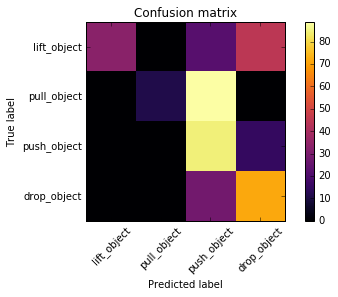

In [7]:
from SAM.SAM_Drivers import testingSegments

yTrainingData = mySAMpy.formatDataFunc(Yall)
testingSegments.testSegments(mySAMpy, yTrainingData, Lall)

------------------------------
3.050s elapsed


Actual  lift_object  Model:  lift_object  with 0.0126 confidence: True

Actual  lift_object  Model:  pull_object  with 0.0062 confidence: False



Actual  pull_object  Model:  pull_object  with 0.0109 confidence: True

Actual  pull_object  Model:  pull_object  with 0.0065 confidence: True



Actual  push_object  Model:  push_object  with 0.0502 confidence: True

Actual  push_object  Model:  push_object  with 0.0173 confidence: True



Actual  push_object  Model:  pull_object  with 0.0125 confidence: False


 0/13 Truth: lift_object Model: lift_object with 0.9873   confidence: True
 1/13 Truth: lift_object Model: pull_object with 0.9937   confidence: False
 2/13 Truth: pull_object Model: lift_object with 0.9693   confidence: False
 3/13 Truth: pull_object Model: pull_object with 0.9939   confidence: True
 4/13 Truth: pull_object Model: pull_object with 0.9890   confidence: True
 5/13 Truth: pull_object Model: pull_object with 0.9934   conf

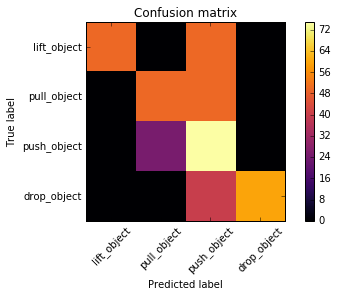

In [8]:
yTrainingData = mySAMpy.formatDataFunc(YtestAll)
testingSegments.testSegments(mySAMpy, yTrainingData, LtestAll)